In [51]:
import pyspark
import folium
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, udf, count, coalesce, lit, concat_ws, split, regexp_replace, trim
import geohash2
import osmnx as ox
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("opdracht_DV") \
    .getOrCreate()

In [76]:
#inladen main dataset
airbnb = spark.read.csv("data/AB_NYC_2019.csv", header=True)
airbnb.printSchema()
airbnb.show(5)

#lon en lat in doubles casten
airbnb = airbnb.withColumn("latitude", col("latitude").cast("double"))\
                .withColumn("longitude", col("longitude").cast("double"))

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)

+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|  host_name|neighbourho

In [77]:
#feature selectie
airbnb = airbnb.select("id", "name", "neighbourhood", "latitude", "longitude", "room_type", "price")
airbnb.show(5)

+----+--------------------+-------------+--------+---------+---------------+-----+
|  id|                name|neighbourhood|latitude|longitude|      room_type|price|
+----+--------------------+-------------+--------+---------+---------------+-----+
|2539|Clean & quiet apt...|   Kensington|40.64749|-73.97237|   Private room|  149|
|2595|Skylit Midtown Ca...|      Midtown|40.75362|-73.98377|Entire home/apt|  225|
|3647|THE VILLAGE OF HA...|       Harlem|40.80902| -73.9419|   Private room|  150|
|3831|Cozy Entire Floor...| Clinton Hill|40.68514|-73.95976|Entire home/apt|   89|
|5022|Entire Apt: Spaci...|  East Harlem|40.79851|-73.94399|Entire home/apt|   80|
+----+--------------------+-------------+--------+---------+---------------+-----+
only showing top 5 rows



In [115]:
nyc_map = folium.Map(location=[40.7128, -74.0060])

for row in airbnb.limit(500).collect():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=3,
        popup=f"Price: {row.price}, {row.name}",
    ).add_to(nyc_map)

nyc_map

In [116]:
#crime dataset inladen
crime = spark.read.csv("data/NYC_crime_20251205.csv", header=True)
crime.printSchema()

root
 |-- CMPLNT_NUM: string (nullable = true)
 |-- ADDR_PCT_CD: string (nullable = true)
 |-- BORO_NM: string (nullable = true)
 |-- CMPLNT_FR_DT: string (nullable = true)
 |-- CMPLNT_FR_TM: string (nullable = true)
 |-- CMPLNT_TO_DT: string (nullable = true)
 |-- CMPLNT_TO_TM: string (nullable = true)
 |-- CRM_ATPT_CPTD_CD: string (nullable = true)
 |-- HADEVELOPT: string (nullable = true)
 |-- JURIS_DESC: string (nullable = true)
 |-- KY_CD: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- LOC_OF_OCCUR_DESC: string (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- PARKS_NM: string (nullable = true)
 |-- PD_CD: string (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- PREM_TYP_DESC: string (nullable = true)
 |-- RPT_DT: string (nullable = true)
 |-- X_COORD_CD: string (nullable = true)
 |-- Y_COORD_CD: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Lat_Lon: string (nullable

In [117]:
#feature selectie
crime = crime.withColumn("Latitude", col("Latitude").cast("double")) \
             .withColumn("Longitude", col("Longitude").cast("double"))

crime = crime.select("Latitude", "Longitude").dropna(subset=["Latitude", "Longitude"])


In [96]:
#pois datset inladen
pois = spark.read.csv("data/CommonPlace.csv", header=True, inferSchema=True)
pois.printSchema()
pois.show(5)

root
 |-- the_geom: string (nullable = true)
 |-- SEGMENTID: integer (nullable = true)
 |-- COMPLEXID: integer (nullable = true)
 |-- SAFTYPE: string (nullable = true)
 |-- PLACEID: integer (nullable = true)
 |-- BIN: integer (nullable = true)
 |-- SOURCE: string (nullable = true)
 |-- OBJECTID: integer (nullable = true)
 |-- SOS INDICATOR: integer (nullable = true)
 |-- FACILITY DOMAINS: integer (nullable = true)
 |-- BOROUGH CODE: integer (nullable = true)
 |-- SOURCE ID: string (nullable = true)
 |-- CREATED_BY: string (nullable = true)
 |-- CREATED_DATE: string (nullable = true)
 |-- MODIFIED_BY: string (nullable = true)
 |-- MODIFIED_DATE: string (nullable = true)
 |-- FACILITY TYPE: integer (nullable = true)
 |-- B7SC: integer (nullable = true)
 |-- PRIMARY ADDRESS POINT ID: integer (nullable = true)
 |-- FEATURE NAME: string (nullable = true)
 |-- SECURITY LEVEL: integer (nullable = true)

+--------------------+---------+---------+-------+-------+-------+------+--------+--------

In [97]:
#feature cleanup
pois = pois.select("the_geom")
pois = pois.withColumn("coords", trim(regexp_replace(col("the_geom"), "POINT\s\(|\)", "")))

pois = pois.withColumn("lon", split(col("coords"), " ").getItem(0).cast("double"))
pois = pois.withColumn("lat", split(col("coords"), " ").getItem(1).cast("double"))

pois = pois.drop("coords", "the_geom")
pois.show(5)

+----------------+---------------+
|             lon|            lat|
+----------------+---------------+
|-74.097961931446|40.634604200807|
|-73.981379489555|40.589105561411|
|-73.943478646583|40.724827480825|
|-73.858490015009|40.708424926703|
|-74.024085858699|40.672444940613|
+----------------+---------------+
only showing top 5 rows



In [98]:
#not null waarden filteren
airbnb = airbnb.filter(col("latitude").isNotNull() & col("longitude").isNotNull())
crime = crime.filter(col("Latitude").isNotNull() & col("Longitude").isNotNull())
pois = pois.filter(col("lat").isNotNull() & col("lon").isNotNull())

#location hashen op hoe dichtbij ze zitten bij elkaar zodat we de crime data, pois en airbnb data kunnen verbinden
def geohash_encode(lat, lon, precision=6):
    return geohash2.encode(lat, lon, precision)
geohash_udf = udf(geohash_encode)

#hash toevoegen aan de kolommen op basis van locatie
airbnb = airbnb.withColumn("geohash", geohash_udf("latitude", "longitude"))
crime = crime.withColumn("geohash", geohash_udf("Latitude", "Longitude"))
pois = pois.withColumn("geohash", geohash_udf("lat", "lon"))

In [103]:
#crime_count en pois_count maken
crime_count = crime.groupBy("geohash").agg(count("*").alias("crime_count"))
pois_count = pois.groupBy("geohash").agg(count("*").alias("pois_count"))


#crime rate en aantal pois toevoegen
airbnb_enriched = airbnb.join(crime_count, on="geohash", how="left").join(pois_count, on="geohash", how="left")

airbnb_enriched = airbnb_enriched.withColumn("crime_count", coalesce("crime_count", lit(0)))
airbnb_enriched = airbnb_enriched.withColumn("pois_count", coalesce("pois_count", lit(0)))

total_pois = airbnb_enriched.agg(sum("pois_count").alias("total_pois"))
total_crime = airbnb_enriched.agg(sum("crime_count").alias("total_crime"))
total_crime.show()
total_pois.show()

+-----------+
|total_crime|
+-----------+
|       3937|
+-----------+

+----------+
|total_pois|
+----------+
|   1803381|
+----------+



In [104]:
airbnb_enriched.show(10)

+-------+----+--------------------+------------------+--------+---------+---------------+-----+-----------+----------+
|geohash|  id|                name|     neighbourhood|latitude|longitude|      room_type|price|crime_count|pois_count|
+-------+----+--------------------+------------------+--------+---------+---------------+-----+-----------+----------+
| dr5rhx|2539|Clean & quiet apt...|        Kensington|40.64749|-73.97237|   Private room|  149|          0|        15|
| dr5ru6|2595|Skylit Midtown Ca...|           Midtown|40.75362|-73.98377|Entire home/apt|  225|          0|        58|
| dr72jm|3647|THE VILLAGE OF HA...|            Harlem|40.80902| -73.9419|   Private room|  150|          0|        82|
| dr5rmn|3831|Cozy Entire Floor...|      Clinton Hill|40.68514|-73.95976|Entire home/apt|   89|          0|        27|
| dr72j7|5022|Entire Apt: Spaci...|       East Harlem|40.79851|-73.94399|Entire home/apt|   80|          0|        61|
| dr5ru9|5099|Large Cozy 1 BR A...|       Murray

In [105]:
map_nyc = folium.Map(location=[40.7128, -74.0060])

for row in airbnb_enriched.limit(500).collect():  # gebruik limit voor performance
    color = "green"
    if row.crime_count == 1:
        color = "orange"
    elif row.crime_count >= 2:
        color = "red"
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=f"Price: {row.price}, POI: {row.pois_count}, Crime: {row.crime_count}"
    ).add_to(map_nyc)

map_nyc


In [106]:
map_nyc = folium.Map(location=[40.7128, -74.0060])

for row in airbnb_enriched.limit(500).collect():  # gebruik limit voor performance
    color = ""
    if row.pois_count < 10:
        color = "red"
    elif row.pois_count <= 40:
        color = "orange"
    elif row.pois_count > 40:
        color = "green"
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=f"Price: {row.price}, POI: {row.pois_count}, Crime: {row.crime_count}"
    ).add_to(map_nyc)

map_nyc


In [107]:
map_nyc = folium.Map(location=[40.7128, -74.0060])

#gewichten
w_crime = 30

for row in airbnb_enriched.limit(500).collect():
    # POI positief, crime negatief
    attractiveness_score = (row.pois_count) - (row.crime_count * w_crime)

    # kleur op basis van aantrekkelijkheid
    if attractiveness_score > 30:
        color = "green"
    elif attractiveness_score > 0:
        color = "orange"
    else:
        color = "red"

    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=6,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=(
            f"Price: {row.price}<br>"
            f"POIs: {row.pois_count}<br>"
            f"Crime: {row.crime_count}<br>"
            f"Aantrekkelijkheid: {attractiveness_score:.1f}"
        )
    ).add_to(map_nyc)

map_nyc


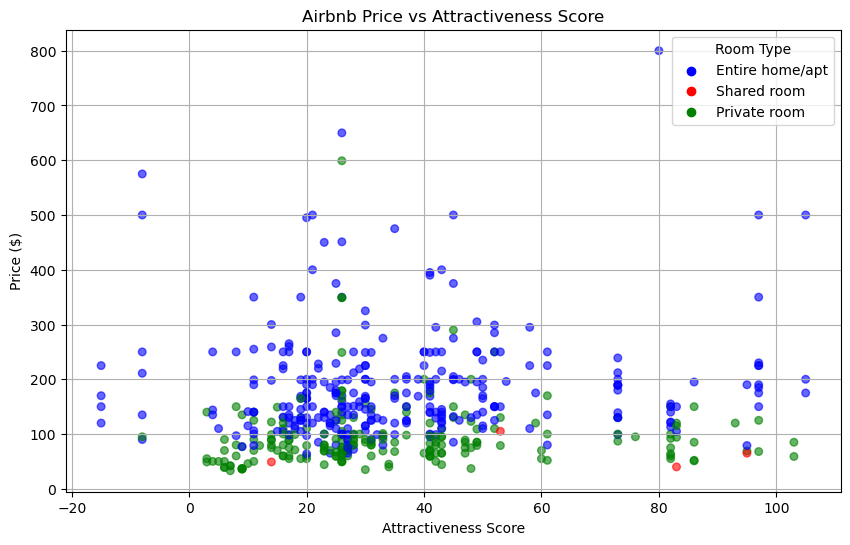

In [108]:
#attractivnes score toevoegen
airbnb_enriched = airbnb_enriched.withColumn("attractiveness_score", col("pois_count") - col("crime_count") * lit(30))

# Spark rows ophalen (bv. 500 om performance-redenen)
rows = airbnb_enriched.select(
    "attractiveness_score", "price", "room_type"
).limit(500).collect()

# Filter en converteer naar float omdat er 1 outlier is
filtered_data = [(row.attractiveness_score, float(row.price), row.room_type)
                 for row in rows
                 if float(row.price) < 1500]

# Omzetten naar Python-lijsten
x = [d[0] for d in filtered_data]
y = [d[1] for d in filtered_data]
labels = [d[2] for d in filtered_data]

# Kleur per room_type
colors = {
    "Entire home/apt": "blue",
    "Private room": "green",
    "Shared room": "red",
    "Hotel room": "purple"
}
point_colors = [colors.get(rt, "gray") for rt in labels]

plt.figure(figsize=(10,6))
plt.scatter(x, y, s=30, alpha=0.6, c=point_colors)

plt.xlabel("Attractiveness Score")
plt.ylabel("Price ($)")
plt.title("Airbnb Price vs Attractiveness Score")

# Legende genereren
unique_types = list(set(labels))
for rt in unique_types:
    plt.scatter([], [], color=colors.get(rt, "gray"), label=rt)

plt.legend(title="Room Type")
plt.grid(True)
plt.show()


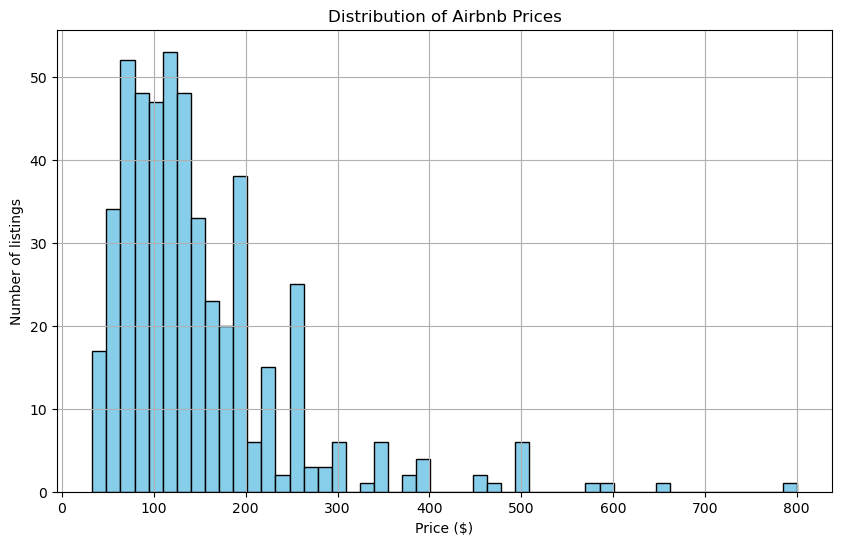

In [109]:
plt.figure(figsize=(10,6))
plt.hist(y, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.title("Distribution of Airbnb Prices")
plt.grid(True)
plt.show()


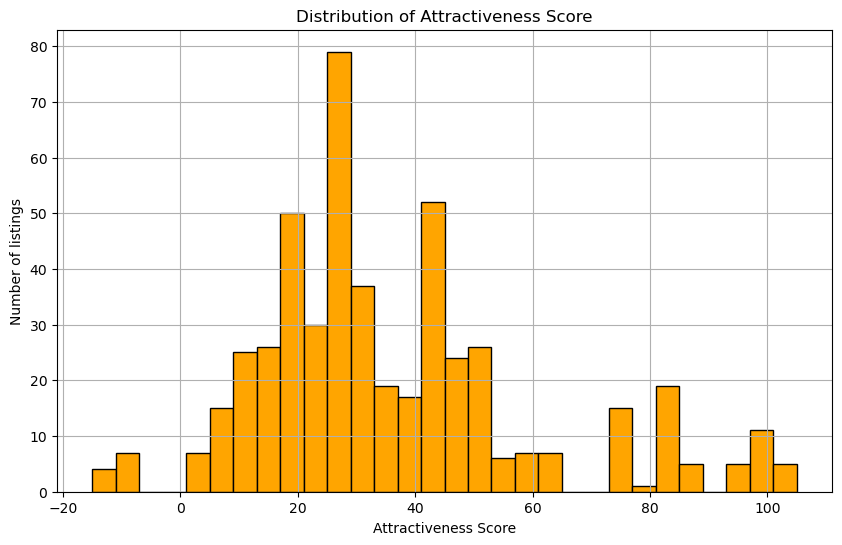

In [110]:
plt.figure(figsize=(10,6))
plt.hist(x, bins=30, color='orange', edgecolor='black')
plt.xlabel("Attractiveness Score")
plt.ylabel("Number of listings")
plt.title("Distribution of Attractiveness Score")
plt.grid(True)
plt.show()


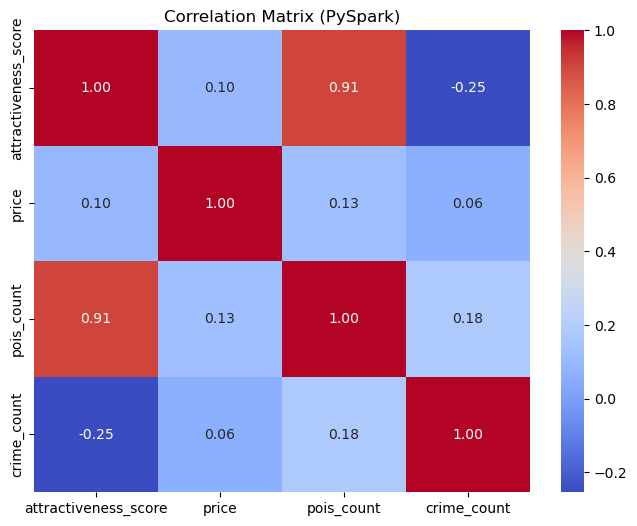

In [111]:
airbnb_numeric = airbnb_enriched.select(
    col("attractiveness_score").cast("double"),
    col("price").cast("double"),
    col("pois_count").cast("double"),
    col("crime_count").cast("double")
)

numeric_cols = ["attractiveness_score","price","pois_count","crime_count"]

correlation_matrix = []
for col1 in numeric_cols:
    row = []
    for col2 in numeric_cols:
        corr_value = airbnb_numeric.stat.corr(col1, col2)
        row.append(corr_value)
    correlation_matrix.append(row)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, xticklabels=numeric_cols, yticklabels=numeric_cols, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (PySpark)")
plt.show()
